In [2]:
# %load ../include/header.py
import numpy as np
import matplotlib.pyplot as plt
from graphenetools import gt
import re,glob,os
from scipy.interpolate import interp1d
from scipy import interpolate
import sys,importlib
# from collections import defaultdict
from numpy import pi as π
import dgutils

import matplotlib.colors as mcolors
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects

# Notebook display options
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
### plot style
plot_style = {'notebook':'../include/notebook.mplstyle','sans':'../include/sans_NC.mplstyle', 'aps':'../include/aps.mplstyle'}
plt.style.reload_library()
plt.style.use(plot_style['aps'])
figsize = plt.rcParams['figure.figsize']

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# setup a possible custom font path
from matplotlib import font_manager
def what_font_path (filename):
    for p in font_manager.findSystemFonts(fontpaths=None, fontext="ttf"):
        if p.find(filename) != -1:
            return p

font_path,bold_font_path = '.','.'
if 'LOCAL_FONT_PATH' in os.environ:
    font_path = os.environ['LOCAL_FONT_PATH'] + os.path.sep + 'HelveticaNeue/HelveticaNeue-Light-08.ttf'
    bold_font_path = os.environ['LOCAL_FONT_PATH'] + os.path.sep + 'HelveticaNeue/HelveticaNeue-Bold-02.ttf'
else:
    # local path (custom)
    font_path = what_font_path('HelveticaNeue-Light-08')
    bold_font_path = what_font_path('HelveticaNeue-Bold-02')

In [4]:
grey = '#a7a7a7'
dgrey = '#303030'

In [5]:
# input data
delta,t,V,Vp = np.genfromtxt('../data/BH_vs_strain.dat',unpack=True,missing_values='N/A')

In [6]:
tinterp = interpolate.CubicSpline(delta,t)
Vinterp = interpolate.CubicSpline(delta,V)
Vpinterp = interpolate.CubicSpline(delta,Vp)
ainterp = interpolate.CubicSpline(delta,np.array(V)/np.array(Vp))

In [7]:
# Define energy list

def gamma(s,a):
    return (s*a - 1)/(a + 1)

def term1(t,mu,s,a):
    return (t + mu/6)

def term2(t,mu,s,a):
    return (t + mu/6)*(t - mu/6 + gamma(s,a))

def term3(t,mu,s,a):
    return 2*t + gamma(s,a)

def e13(t,mu,s,a):
    return (-mu - 3/(a + 1))*16

def e23(t,mu,s,a):
    return (-2*mu + (3*s*a - 6)/(a + 1))*16

def e33(t,mu,s,a):
    return (-3*mu + 9*(s*a - 1)/(a + 1))*16

def e716(t,mu,s,a):
#     return -21*mu + 18*s*a/(a + 1) - 36/(a + 1)
    return -21*mu + 27*(s*a - 1)/(a + 1)

def esf(t,mu,s,a):
    return (-9*(t + mu/6)**2/(2*t + gamma(s,a)))*16

def lst(t,mu,s,a):
    if (term2(t,mu,s,a) > 0 \
        and 1 >= term1(t,mu,s,a)/term3(t,mu,s,a) \
        and term1(t,mu,s,a)/term3(t,mu,s,a) > 0):
        return [e13(t,mu,s,a), e716(t,mu,s,a), e23(t,mu,s,a), e33(t,mu,s,a), esf(t,mu,s,a), 0.0]
    else:
        return [e13(t,mu,s,a), e716(t,mu,s,a), e23(t,mu,s,a), e33(t,mu,s,a), 999999.0, 0.0]

def pref_state(t,mu,s,a):
    return lst(t,mu,s,a).index(min(lst(t,mu,s,a)))

def pref_state_SS_included(t,mu,s,a, SS_energy = 999999.0):
    lst_new = lst(t,mu,s,a)
    lst_new.append(SS_energy)
    return lst_new.index(min(lst_new))

In [8]:
nx = 1001
ny = 1001

delta_new = np.linspace(0, 0.3, nx)

tnew = tinterp(delta_new)   # use interpolation function returned by `interp1d`
Vnew = Vinterp(delta_new)
Vpnew = Vpinterp(delta_new)
anew = ainterp(delta_new)

a_lst = [-x/y if x>=0 else x/y for x, y in zip(Vnew,Vpnew)]
s_lst = [1 if x>=0 else -1 for x in Vnew]
norm = [x-y if x>=0 else -x-y for x, y in zip(Vnew,Vpnew)]

mu_new = np.linspace(-20,40,ny)
tbar = [x/y for x, y in zip(tnew,norm)]

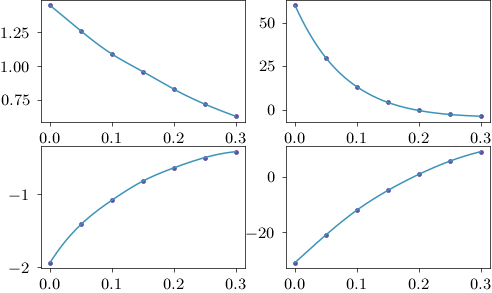

In [8]:
fig, axs = plt.subplots(2, 2)
axs[0,0].plot(delta, t, 'o', delta_new, tnew, '-')
axs[0,1].plot(delta, V, 'o', delta_new, Vnew, '-')
axs[1,0].plot(delta, Vp, 'o', delta_new, Vpnew, '-')
axs[1,1].plot(delta, np.array(V)/np.array(Vp), 'o', delta_new, anew, '-');

# Abstract PD

# a = 33 (0% strain)

In [9]:
def get_cmap(phases):
    colors = {'0.0':'#22b2aa55', '2.0':'#22b2aa99', 
              '3.0':'#22b2aa', '4.0':'coral', 
              '5.0':'#e6e2dc', '6.0':'#FEFF60'}
    return mcolors.ListedColormap([colors[str(p)] for p in phases])

def ab_pdmaker (ax,t, mu, data, VoVp, show_grid=False, grid_scale=1, locate_system=None, 
               labels=None, label_loc=None):
    
    phases = np.unique(data)
    cMap = get_cmap(phases)
    p1 = ax.contourf(t, mu, data, len(phases), vmin = np.min(phases), vmax = np.max(phases), cmap = cMap)

    ax.set_xlabel(r'$t\,/\,\left(|V|+|V^{\prime}|\right)$')
    ax.set_ylabel(r'$\mu\,/\,\left(|V|+|V^{\prime}|\right)$')

    #ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlim(0,0.69)
    ax.set_ylim(-7.9,7.9)
    
    # Add a x to specify the system location
    if locate_system is not None:
        if locate_system[2] == 'a':
            ax.annotate("",xy=(locate_system[0],locate_system[1]), xycoords='data',xytext=(0.1,-2.5),
                       arrowprops=dict(arrowstyle="-|>",color='k',lw=0.5,shrinkA=0.02,shrinkB=0.02))
            ax.annotate(r'$^4$He on graphene',xy=(0.05,-2.5), xycoords='data',xytext=(0.05,-2.5),
                       ha='left',va='top' )
            ax.plot(*locate_system[:2], marker='x', color='k', ms=4) #mew=0.5,?
        elif locate_system[2] == 'c' or locate_system[2] == 'd':
#             ax.annotate("",xy=(locate_system[0],locate_system[1]), xycoords='data',xytext=(0.55,-2),
#                        arrowprops=dict(arrowstyle="-|>",color='k',lw=0.5,shrinkA=0.02,shrinkB=0.02))
            ax.plot(*locate_system[:2], marker='x', color='k', ms=4)
        
    # Add some possible phase labels
    if labels is not None:
        path_eff = [path_effects.withSimplePatchShadow(offset=(0.05, -0.05), shadow_rgbFace='k', alpha=0.9)]

        for lab,loc in zip(labels,label_loc):
            col='k'
            ax.text(*loc, lab, va='center',ha='left', color=col, path_effects=path_eff)
            
    # add the V/V' label
    ax.text(0.685,7.75, r'$V\,/\,|V^\prime| \simeq $' + f'{VoVp}', va='top',ha='right')

    return ax

In [10]:
# def get_cmap(phases):
#     colors = {'0.0':'#22b2aa55', '2.0':'#22b2aa99', 
#               '3.0':'#22b2aa', '4.0':'coral', 
#               '5.0':'#e6e2dc', '6.0':'#FEFF60'}
#     return mcolors.ListedColormap([colors[str(p)] for p in phases])

# def ab_pdmaker (ax,t, mu, data, dt, dmu, VoVp, show_grid=False, grid_scale=1, locate_system=None, 
#                labels=None, label_loc=None):
    
#     phases = np.unique(data)
#     cMap = get_cmap(phases)
#     p1 = ax.contourf(t, mu, data, len(phases), vmin = np.min(phases), vmax = np.max(phases), cmap = cMap)

#     ax.set_xlabel(r'$t\,/\,\left(|V|+|V^{\prime}|\right)$')
#     ax.set_ylabel(r'$\mu\,/\,\left(|V|+|V^{\prime}|\right)$')

#     #ax.tick_params(axis='both', which='major', labelsize=14)
#     ax.set_xlim(0,0.69)
#     ax.set_ylim(-7.9,7.9)
    
#     if show_grid:
#         xgridset = np.arange(0, 0.7, dt)
#         ygridset = np.arange(-8, 8, dmu)

#         ax.set_xticks(xgridset, minor=True)
#         ax.set_yticks(ygridset, minor=True)
#         ax.grid(which='minor', color='dodgerblue', linewidth=0.6)
#         ax.tick_params(which='minor', bottom=False, left=False)
        
#     else:
#         rect = patches.Rectangle((0.01, -7.7), dt*grid_scale, dmu*grid_scale, ec=dgrey, fill=False, 
#                                  lw=0.35)
#         ax.add_patch(rect)
#         scale_text = ''
#         if grid_scale > 1:
#             scale_text = f'{grid_scale}' + r'$\times\,$'
#         ax.text(0.015+dt*grid_scale, -7.8, scale_text + 'grid size', va='bottom',ha='left', color=dgrey)
        
#     # Add a x to specify the system location
#     if locate_system is not None:
        
#         ax.annotate("",xy=(locate_system[0],locate_system[1]), xycoords='data',xytext=(0.1,-2.5),
#                    arrowprops=dict(arrowstyle="-|>",color='k',lw=0.5,shrinkA=0.02,shrinkB=0.02))
#         ax.annotate(r'$^4$He on graphene',xy=(0.05,-2.5), xycoords='data',xytext=(0.05,-2.5),
#                    ha='left',va='top' )
#         ax.plot(*locate_system, marker='x', color='k', mew=0.5, ms=2)
        
#     # Add some possible phase labels
#     if labels is not None:
#         path_eff = [path_effects.withSimplePatchShadow(offset=(0.05, -0.05), shadow_rgbFace='k', alpha=0.9)]

#         for lab,loc in zip(labels,label_loc):
#             col='k'
#             ax.text(*loc, lab, va='center',ha='left', color=col, path_effects=path_eff)
            
#     # add the V/V' label
#     ax.text(0.685,7.75, r'$V\,/\,|V^\prime| \simeq $' + f'{VoVp}', va='top',ha='right')

#     return ax

In [11]:
def get_pd_data(nx,ny,s,a,delta,V,Vp):
    
    ab_tbar = np.linspace(0,0.7,nx)
    ab_mubar = np.linspace(-8,8,ny)
    ab_data = np.zeros((ny,nx))
    
    ainterp_2 = interpolate.CubicSpline(delta,np.array(V)/np.array(Vp)+s*a)
    root = ainterp_2.roots()[1]
    samplet = tinterp(root)
    sampleV = Vinterp(root)
    sampleVp = Vpinterp(root)
    
#     dt = 0.2/(abs(sampleV)+abs(sampleVp))
#     dmu = 5/(abs(sampleV)+abs(sampleVp))

    for i in range(nx):
        for j in range(ny):
            ab_data[j,i] = pref_state(ab_tbar[i],ab_mubar[j],s,a)
            
    return ab_tbar, ab_mubar, ab_data, samplet, sampleV, sampleVp
# dt and dmu is dimentionless parameter from 0.2 K and 5 K.

In [12]:
# Supersolid part
# t, mu, psi_a, psi_b, rho_a, rho_b, E1/3, E2/3, E3/3, ESS, ESF 
ss_raw30 = np.genfromtxt('../data/SWData_r_30_large.csv', delimiter=",")
ss_raw1 = np.genfromtxt('../data/SWData_r_1_large.csv', delimiter=",")

In [13]:
def min_energy(lst):
    lst.append(0.0)
    lst = [round(x, 12) for x in lst]
    min_val = min(lst)
    if lst[0] == min_val:
        return 0
    if lst[1] == min_val:
        return 2
    if lst[2] == min_val:
        return 3
    if lst[4] == min_val:
        return 4
    if lst[3] == min_val:
        return 6
    if min_val == 0.0:
        return 5

In [14]:
ss_t30 = np.unique(ss_raw30[:,0])
ss_mu30 = np.unique(ss_raw30[:,1])
ss_t1 = np.unique(ss_raw1[:,0])
ss_mu1 = np.unique(ss_raw1[:,1])
ss_raw30 = ss_raw30.reshape((len(ss_mu30),len(ss_t30),11))
ss_raw1 = ss_raw1.reshape((len(ss_mu1),len(ss_t1),11))

In [15]:
def find_symmetry_line(s, a):
    return (3*s*a - 3)/(a + 1)

def find_idx(mulst, mu_line):
    for i, mu in enumerate(mulst):
        if mu > mu_line:
            return i

def replace_ssdata(rawdata, line_at):
    assert len(rawdata[:,0,0])/2-1 < line_at, 'Symmetry line is below half mu'
    for j in range(len(rawdata[:,0,0])):
        if j > line_at:
            for i in range(len(rawdata[0,:,0])):
#                 rawdata[j,i,-2] = rawdata[2*line_at-j,i,-2]
                rawdata[j,i,-2] = 999999
    return rawdata

In [16]:
sym_line_at30 = find_idx(ss_mu30, find_symmetry_line(1,30))
sym_line_at1 = find_idx(ss_mu1, find_symmetry_line(1,1))

# ss_data30 = replace_ssdata(ss_raw30, sym_line_at30)
# ss_data1 = replace_ssdata(ss_raw1, sym_line_at1)
ss_data30 = ss_raw30
ss_data1 = ss_raw1

In [17]:
small_pd_data30 = np.zeros((len(ss_mu30), len(ss_t30)))
small_pd_data1 = np.zeros((len(ss_mu1), len(ss_t1)))

for j in range(len(ss_mu30)):
    for i in range(len(ss_t30)):
        if term2(ss_t30[i], ss_mu30[j], 1, 30)>0:
            mylst = list(ss_data30[j,i,-5:])
            small_pd_data30[j,i] = min_energy(mylst)
        else:
            mylst = list(ss_data30[j,i,-5:-1])
            mylst.append(999999)
            small_pd_data30[j,i] = min_energy(mylst)

for j in range(len(ss_mu1)):
    for i in range(len(ss_t1)):
        if term2(ss_t1[i], ss_mu1[j], 1, 1)>0:
            mylst = list(ss_data1[j,i,-5:])
            small_pd_data1[j,i] = min_energy(mylst)
        else:
            mylst = list(ss_data1[j,i,-5:-1])
            mylst.append(999999)
            small_pd_data1[j,i] = min_energy(mylst)

In [18]:
def replace_phase(pddata, line_at):
    assert len(pddata)/2-1 < line_at, 'Symmetry line is below half mu'
    for j in range(len(pddata)):
        if j >= line_at-1:
            for i in range(len(pddata[0,:])):
                if pddata[2*line_at-j-1,i] == 6:
                    pddata[j,i] = 6
    return pddata

In [19]:
small_pd_data30_v2 = replace_phase(small_pd_data30,sym_line_at30)
small_pd_data1_v2 = replace_phase(small_pd_data1,sym_line_at1)

In [20]:
ss_data30_set = [ss_t30, ss_mu30, small_pd_data30_v2]
ss_data1_set = [ss_t1, ss_mu1, small_pd_data1_v2]

In [21]:
data_pd = {}
data_pd['a=30'] = get_pd_data(nx,ny,1,30,delta,V,Vp)
data_pd['a=-1'] = get_pd_data(nx,ny,-1,1,delta,V,Vp)
data_pd['a=1'] = get_pd_data(nx,ny,1,1,delta,V,Vp)

In [22]:
def is_increment(a1, a2):
    return round(a1[1]-a1[0], 5) == round(a2[1]-a2[0],5)

def substitutor(data_set, ssdata_set):
    if is_increment(data_set[0], ssdata_set[0]) and is_increment(data_set[1], ssdata_set[1]):
        t_idx = np.where(data_set[0] == ssdata_set[0][0])[0][0]
        mu_idx = np.where(data_set[1] == ssdata_set[1][0])[0][0]
        
        for j in range(len(data_set[1])):
            for i in range(len(data_set[0])):
                if i >= t_idx and i < t_idx+len(ssdata_set[0])\
                and j >= mu_idx and j < mu_idx+len(ssdata_set[1]):
                    data_set[2][j,i] = ssdata_set[2][j-mu_idx,i-t_idx]
        return data_set
    else:
        print('cannot replace data')
        return data_set

In [23]:
data_pd_revised30 = substitutor(data_pd['a=30'], ss_data30_set)
data_pd_revised1 = substitutor(data_pd['a=1'], ss_data1_set)

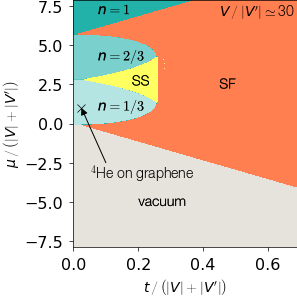

In [24]:
plt.style.reload_library()
with plt.style.context(plot_style['sans']):
    
    fig,ax = plt.subplots(1,1,figsize=(figsize[1],figsize[1]),constrained_layout=True)
    dgutils.fonts.set_custom_font(font_path)
    
    labels=['vacuum','SF',r'$n=1/3$',r'$n=2/3$',r'$n=1$','SS']
    label_loc = [[0.2,-5],[0.45,2.5],[0.075,1.1],[0.075,4.3],[0.075,7.25],[0.18,2.7]]
    [t_current,V_current,Vp_current] = data_pd_revised30[-3:]
    tloc = t_current/(np.abs(V_current) + np.abs(Vp_current))
    muloc = 1
    ax = ab_pdmaker(ax,*data_pd_revised30[:-3], 30,
                   locate_system=[tloc,muloc,'a'], 
                   labels=labels,label_loc=label_loc)
#    fig.savefig('../figures/MFpd_delta_0.00.pdf')

# a = 1

### Find the value of strain where V/V' = -1

δ = 0.183


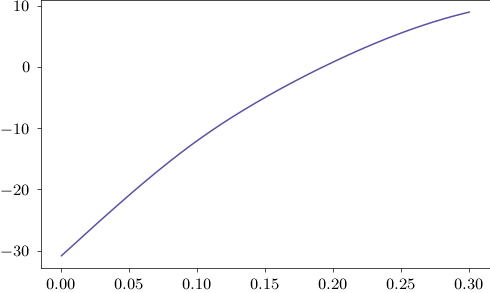

In [25]:
δ = np.linspace(0, 0.3, 10000)
VoVp = ainterp(δ)
plt.plot(δ,VoVp)

idx = np.where(np.abs(VoVp+1) < 1E-2)[0][0]
cδ = δ[idx]
print(f'δ = {δ[idx]:.3f}')

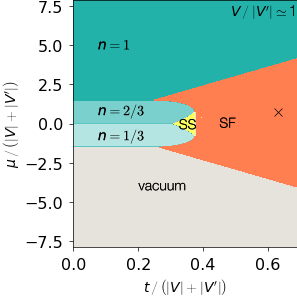

In [26]:
plt.style.reload_library()
with plt.style.context(plot_style['sans']):
    
    fig,ax = plt.subplots(1,1,figsize=(figsize[1],figsize[1]),constrained_layout=True)
    dgutils.fonts.set_custom_font(font_path)
    
    labels=['vacuum','SF',r'$n=1/3$',r'$n=2/3$',r'$n=1$','SS']
    label_loc = [[0.2,-4.0],[0.45,0],[0.075,-0.8],[0.075,0.8],[0.075,5],[0.325,-0.1]]
    [t_current,V_current,Vp_current] = data_pd_revised1[-3:]
    tloc = t_current/(np.abs(V_current) + np.abs(Vp_current))
    muloc = 1/(np.abs(V_current) + np.abs(Vp_current))
    ax = ab_pdmaker(ax,*data_pd_revised1[:-3] ,1,
                    locate_system=[tloc,muloc,'c'],
                    labels=labels,label_loc=label_loc)

#    fig.savefig(f'../figures/MFpd_delta_{cδ:4.2f}.pdf')

# s = -1, a = 1 (both attractive)

In [27]:
idx = np.where(np.abs(VoVp-1) < 1E-2)[0][0]
cδ = δ[idx]
print(f'δ = {δ[idx]:.3f}')

δ = 0.201


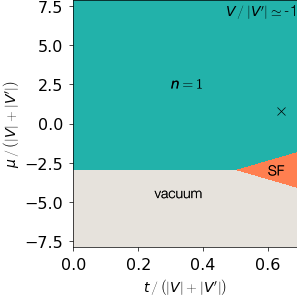

In [28]:
plt.style.reload_library()
with plt.style.context(plot_style['sans']):
    
    fig,ax = plt.subplots(1,1,figsize=(figsize[1],figsize[1]),constrained_layout=True)
    dgutils.fonts.set_custom_font(font_path)
    
    labels=['vacuum','SF',r'$n=1$']
    label_loc = [[0.25,-4.5],[0.6,-3.05],[0.3,2.5]]
    [t_current,V_current,Vp_current] = data_pd['a=-1'][-3:]
    tloc = t_current/(np.abs(V_current) + np.abs(Vp_current))
    muloc = 1/(np.abs(V_current) + np.abs(Vp_current))
    ax = ab_pdmaker(ax,*data_pd['a=-1'][:-3], -1,
                    locate_system=[tloc,muloc,'d'],
                    labels=labels,label_loc=label_loc)

#    fig.savefig(f'../figures/MFpd_delta_{cδ:4.2f}.pdf')

## Decorate the Strained Lattice

In [12]:
def get_unit_vec(start,end):
    end = np.array(end)
    start = np.array(start)
    vec = end-start
    length = np.linalg.norm(vec)
    vec /= length
    return vec,length

In [56]:
import matplotlib as mpl
from Bezier import Bezier

# lattice vectors
aₒ = 1.42
a = (aₒ/2)*np.array([[np.sqrt(3),-np.sqrt(3)],[3,3]])

def decorate_graphene(ax):
    im = plt.imread('../figures/V_Vp_He_graphene.png')
    ax.imshow(im,interpolation='none',extent=[-5.15,5.15,-4.5,4.5])

    # V interaction
    start,end = [0,0],[-a[0,0],a[1,0]]
    vec,length = get_unit_vec(start,end)
    V = np.array(dgutils.pypov.generate_linear_path(start + 0.2*length*vec, end - 0.15*length*vec,200))
    Vtext = start + 0.66*vec*length
    Vtext[0] += 0.25
    Vtext[1] += 0.3

    # V' interaction
    start,end = [-a[0,0],-a[1,0]],[-a[0,0],a[1,0]]
    mid = [-2.5*a[0,0],0]
    vec1,length1 = get_unit_vec(start,mid)
    vec2,length2 = get_unit_vec(mid,end)
    Vptext = mid
    Vptext[0] += 0.6

    t_points = np.linspace(0, 1, 1000) 
    points = np.array([start + 0.15*length1*vec1,mid,end - 0.15*length2*vec2])
    curve = Bezier.Curve(t_points, points)

    vec,length = get_unit_vec(start,end)

    with mpl.rc_context({'path.sketch': (1.5, 5, 1)}):
        ax.plot(V[:,0],V[:,1], lw=0.5, color=grey)
        ax.plot(curve[:,0],curve[:,1], lw=0.5, color=grey)
        
    # Plot the distance between two points
    _x0 = [a[0,0],2*a[0,0]]
    _y0 = [-a[1,0],0]
    # ax.plot(_x0,_y0, lw=1, color=grey, ls='--')
    
    ax.annotate("",xy=(_x0[0],_y0[0]), xycoords='data',xytext=(_x0[1],_y0[1]),
                       arrowprops=dict(arrowstyle="<|-|>",color=grey,lw=0.5,shrinkA=0.02,shrinkB=0.02))
    
    # Add some text labels
    dgutils.fonts.set_custom_font(font_path)
    path_eff = [path_effects.withSimplePatchShadow(offset=(0.1, -0.1), shadow_rgbFace='k', alpha=1.0)]

    ax.text(*Vtext,r'$V(\delta)$',ha='center',va='center', color=dgrey,
            path_effects=path_eff)
    ax.text(*Vptext,r'$V^\prime(\delta)$',ha='center',va='center', color=dgrey,
            path_effects=path_eff)
    ax.text(1.5*a[0,0],0.35,r'$t(\delta)$',ha='center',va='center', color=dgrey,
            path_effects=path_eff)
    ax.text(2.12,1.7*a[1,0],r'$a_0(1+\delta)$',ha='center',va='center', color=dgrey,
            path_effects=path_eff, rotation=-30)
    
    ax.text(3.9,0.01,'strain',ha='left', va='center',color='white',fontsize=5)
    ax.text(-3.9,0.01,'strain',ha='right',va='center',color='white',fontsize=5)
    
    ax.text(-0.09,3.8,'strain',va='center',color='white',rotation=90,fontsize=5)
    ax.text(-0.09,-3.75,'strain',va='center',ha='left',color='white',rotation=90,fontsize=5)
    
    ax.text(1.66*a[0,0],-0.75,r'$\sqrt{3}a_0$',ha='left',va='center', color=dgrey,
            path_effects=path_eff)

    ax.patch.set_alpha(0.0)

    ax.axis('off');

    
    return ax

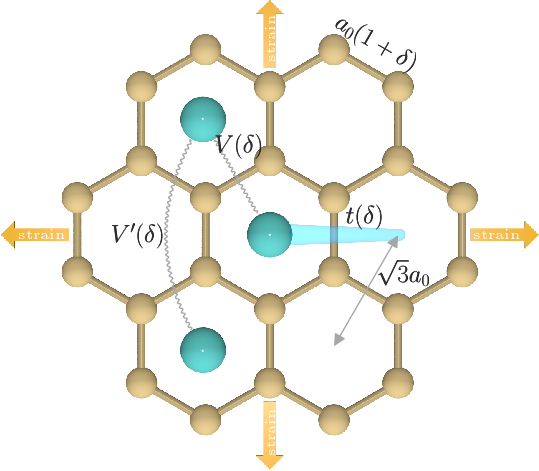

In [57]:
plt.style.reload_library()
with plt.style.context(plot_style['aps']):
    fig,ax = plt.subplots(figsize=((4/5)*figsize[0],(4/5)*figsize[0]),constrained_layout=True)
    dgutils.fonts.set_custom_font(font_path)
    
    ax = decorate_graphene(ax)

    fig.savefig('../figures/biaxial_strain.pdf')

## Create the Combined Figure

0.024524428701271465 1
0.6300339997846739 0.7214099531725415
0.6411955399619292 0.7758883740177822


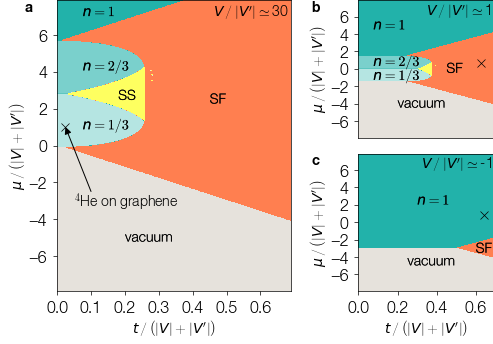

In [36]:
plt.style.reload_library()
with plt.style.context(plot_style['sans']):
    
    dgutils.fonts.set_custom_font(font_path)

    fig = plt.figure(figsize=(1.0*figsize[0],(0.7)*figsize[0]), constrained_layout=True)
    
    pd0_fig,pd_fig = fig.subfigures(nrows=1,ncols=2, width_ratios=[1.5,1])
    ax_pd0 = pd0_fig.subplots(1,1)
    ax_pd = pd_fig.subplots(nrows=2,ncols=1)
    
    labels=['vacuum','SF',r'$n=1/3$',r'$n=2/3$',r'$n=1$','SS']
    label_loc = [[0.2,-5],[0.45,2.5],[0.075,1.1],[0.075,4.3],[0.075,7.25],[0.18,2.7]]
    [t_current,V_current,Vp_current] = data_pd_revised30[-3:]
    tloc = t_current/(np.abs(V_current) + np.abs(Vp_current))
    muloc = 1
    ax_pd0 = ab_pdmaker(ax_pd0,*data_pd_revised30[:-3], 30,
                   locate_system=[tloc,muloc,'a'], 
                   labels=labels,label_loc=label_loc)
    print(tloc,muloc)

    labels=['vacuum','SF',r'$n=1/3$',r'$n=2/3$',r'$n=1$',]
    label_loc = [[0.2,-4.0],[0.45,0],[0.075,-0.8],[0.075,0.8],[0.075,5],]
    [t_current,V_current,Vp_current] = data_pd_revised1[-3:]
    tloc = t_current/(np.abs(V_current) + np.abs(Vp_current))
    muloc = 1/(np.abs(V_current) + np.abs(Vp_current))
    print(tloc,muloc)
    ax_pd[0] = ab_pdmaker(ax_pd[0],*data_pd_revised1[:-3] ,1,
                    locate_system=[tloc,muloc,'c'],
                    labels=labels,label_loc=label_loc)
    ax_pd[0].xaxis.set_visible(False)
    
    labels=['vacuum','SF',r'$n=1$']
    label_loc = [[0.25,-4.5],[0.6,-3.05],[0.3,2.5]]
    [t_current,V_current,Vp_current] = data_pd['a=-1'][-3:]
    tloc = t_current/(np.abs(V_current) + np.abs(Vp_current))
    muloc = 1/(np.abs(V_current) + np.abs(Vp_current))
    print(tloc,muloc)
    ax_pd[1] = ab_pdmaker(ax_pd[1],*data_pd['a=-1'][:-3], -1,
                    locate_system=[tloc,muloc,'d'],
                    labels=labels,label_loc=label_loc)
    
    # add panel labels
    font_props = dgutils.fonts.get_custom_font_props(bold_font_path)

    ax_pd0.text(-0.14,1.0,'a', ha='left',va='top', transform=ax_pd0.transAxes, fontproperties=font_props) 
#     fig.text(2/5,0.98,'b', ha='left',va='top',fontproperties=font_props)

    #ax_G.text(0,1,'b',ha='left',va='top',transform=ax_G.transAxes, fontproperties=font_props)
    for i,lab in enumerate(['b','c']):
        ax_pd[i].text(-0.35,1.0,lab,ha='left',va='top',transform=ax_pd[i].transAxes, fontproperties=font_props)
    
    fig.savefig('../figures/mf_phase_diagrams_small.pdf')
#     fig.savefig('../figures/mf_phase_diagrams.svg')

In [32]:
# plt.style.reload_library()
# with plt.style.context(plot_style['sans']):
    
#     dgutils.fonts.set_custom_font(font_path)

#     fig = plt.figure(figsize=(2*figsize[0],(4/5)*figsize[0]), constrained_layout=True)

    
#     pd0_fig,G_fig,pd_fig = fig.subfigures(nrows=1,ncols=3, width_ratios=[2,2,1])
#     ax_pd0 = pd0_fig.subplots(1,1)
#     ax_G = G_fig.subplots(1,1)
#     ax_pd = pd_fig.subplots(nrows=2,ncols=1)
    
# #     labels=['vacuum','SF',r'$n=1/3$',r'$n=2/3$',r'$n=1$']
# #     label_loc = [[0.25,-5],[0.45,2.5],[0.075,1.4],[0.075,4.2],[0.075,7.25]]
# #     ax_pd0 = ab_pdmaker(ax_pd0,*data_pd['a=33'], 30,grid_scale=10,
# #                    locate_system=[t[0]/(np.abs(V[0]) + np.abs(Vp[0])),1], 
# #                    labels=labels,label_loc=label_loc)
#     labels=['vacuum','SF',r'$n=1/3$',r'$n=2/3$',r'$n=1$','SS']
#     label_loc = [[0.2,-5],[0.45,2.5],[0.075,1.1],[0.075,4.3],[0.075,7.25],[0.18,2.7]]
#     [t_current,V_current,Vp_current] = data_pd_revised30[-3:]
#     tloc = t_current/(np.abs(V_current) + np.abs(Vp_current))
#     muloc = 1
#     ax_pd0 = ab_pdmaker(ax_pd0,*data_pd_revised30[:-3], 30,
#                    locate_system=[tloc,muloc,'a'], 
#                    labels=labels,label_loc=label_loc)
#     print(tloc,muloc)
# #     ax_pd0 = ab_pdmaker(ax_pd0,*data_pd_revised30, 30,grid_scale=10,
# #                    locate_system=[t[0]/(np.abs(V[0]) + np.abs(Vp[0])),1], 
# #                    labels=labels,label_loc=label_loc)
    
#     ax_G = decorate_graphene(ax_G)
#     ax_G.patch.set_alpha(1.0)

    
# #     labels=['vacuum','SF',r'$n=1/3$',r'$n=2/3$',r'$n=1$']
# #     label_loc = [[0.2,-4.0],[0.45,0],[0.075,-0.8],[0.075,0.8],[0.075,5]]
# #     ax_pd[0] = ab_pdmaker(ax_pd[0],*data_pd['a=1'],1,labels=labels,label_loc=label_loc)
# #     ax_pd[0].xaxis.set_visible(False)
#     labels=['vacuum','SF',r'$n=1/3$',r'$n=2/3$',r'$n=1$',]
#     label_loc = [[0.2,-4.0],[0.45,0],[0.075,-0.8],[0.075,0.8],[0.075,5],]
#     [t_current,V_current,Vp_current] = data_pd_revised1[-3:]
#     tloc = t_current/(np.abs(V_current) + np.abs(Vp_current))
#     muloc = 1/(np.abs(V_current) + np.abs(Vp_current))
#     print(tloc,muloc)
#     ax_pd[0] = ab_pdmaker(ax_pd[0],*data_pd_revised1[:-3] ,1,
#                     locate_system=[tloc,muloc,'c'],
#                     labels=labels,label_loc=label_loc)
# #     ax_pd[0] = ab_pdmaker(ax_pd[0],*data_pd_revised1,1,labels=labels,label_loc=label_loc)
#     ax_pd[0].xaxis.set_visible(False)
    
#     labels=['vacuum','SF',r'$n=1$']
#     label_loc = [[0.25,-4.5],[0.6,-3.05],[0.3,2.5]]
#     [t_current,V_current,Vp_current] = data_pd['a=-1'][-3:]
#     tloc = t_current/(np.abs(V_current) + np.abs(Vp_current))
#     muloc = 1/(np.abs(V_current) + np.abs(Vp_current))
#     print(tloc,muloc)
#     ax_pd[1] = ab_pdmaker(ax_pd[1],*data_pd['a=-1'][:-3], -1,
#                     locate_system=[tloc,muloc,'d'],
#                     labels=labels,label_loc=label_loc)
# #     ax_pd[1] = ab_pdmaker(ax_pd[1],*data_pd['a=-1'],-1,labels=labels,label_loc=label_loc)
    
#     # add panel labels
#     font_props = dgutils.fonts.get_custom_font_props(bold_font_path)

#     ax_pd0.text(-0.14,1.0,'a', ha='left',va='top', transform=ax_pd0.transAxes, fontproperties=font_props) 
#     #ax_pd0.text(1.05,1.0,'b', ha='left',va='top', transform=ax_pd0.transAxes, fontproperties=font_props) 

#     plt.figtext(0.3934,0.98,'b', ha='left',va='top',fontproperties=font_props,zorder=10)

#     #ax_G.text(0,0.99,'b',ha='left',va='top',transform=ax_G.transAxes, fontproperties=font_props)
#     for i,lab in enumerate(['c','d']):
#         ax_pd[i].text(-0.35,1.0,lab,ha='left',va='top',transform=ax_pd[i].transAxes, fontproperties=font_props)
    
#     fig.savefig('../figures/mf_phase_diagrams.pdf')
#     fig.savefig('../figures/mf_phase_diagrams.svg')

In [33]:
# tinterp(0.183)/(np.abs(Vinterp(0.183))+np.abs(Vpinterp(0.183)))

# tinterp(0.157)/(np.abs(Vinterp(0.157))+np.abs(Vpinterp(0.157)))


# Physical PD

In [37]:
# new set of strain for physical PD
delta_PPD = np.arange(0,0.28,0.001)
mu_PPD = np.arange(-20,40,0.2)
nx_PPD = len(delta_PPD)
ny_PPD = len(mu_PPD)
t_PPD = tinterp(delta_PPD)
V_PPD = Vinterp(delta_PPD)
Vp_PPD = Vpinterp(delta_PPD)

a_PPD = [-x/y if x>=0 else x/y for x, y in zip(V_PPD,Vp_PPD)]
s_PPD = [1 if x>=0 else -1 for x in V_PPD]
norm_PPD = [x-y if x>=0 else -x-y for x, y in zip(V_PPD,Vp_PPD)]
tbar_PPD = [x/y for x, y in zip(t_PPD,norm_PPD)]

In [38]:
# Without Supersolid
mubar_PPD = np.zeros((ny_PPD,nx_PPD))
data_PPD = np.zeros((ny_PPD,nx_PPD))
for i in range(nx_PPD):
    for j in range(ny_PPD):
        mubar_PPD[j,i] = mu_PPD[j]/norm_PPD[i]

for i in range(nx_PPD):
    for j in range(ny_PPD):
        data_PPD[j,i] = pref_state(tbar_PPD[i],mubar_PPD[j,i],s_PPD[i],a_PPD[i])

In [39]:
idxarr = np.argwhere(data_PPD==4)
sortedArr = idxarr[idxarr[:,1].argsort()]

### The first lobe split

46


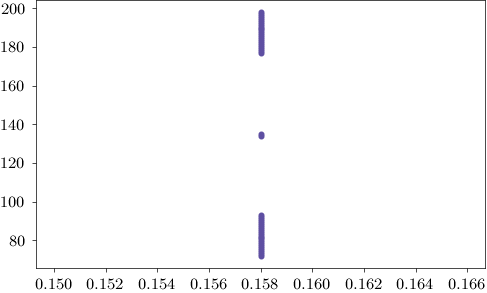

In [40]:
# argArr = np.argwhere((sortedArr[:,1]>500)&(sortedArr[:,1]<570))
delta_number = 158
argArr = np.argwhere((sortedArr[:,1]==delta_number))
print(len(argArr))
target = sortedArr[argArr[0][0]:argArr[-1][0]+1]
targetsorted = target[target[:,0].argsort()]
plt.scatter([delta_PPD[delta_number],]*len(targetsorted),targetsorted[:,0])

In [41]:
targetsorted[:,0]

array([ 72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
        85,  86,  87,  88,  89,  90,  91,  92,  93, 134, 135, 177, 178,
       179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
       192, 193, 194, 195, 196, 197, 198])

### The end of tow lobe

91


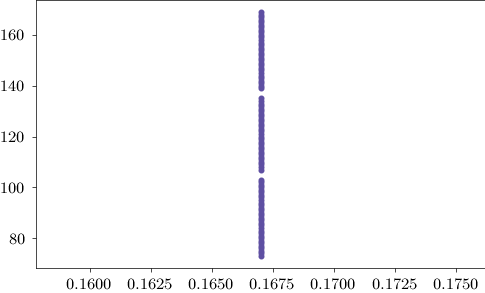

In [42]:
# argArr = np.argwhere((sortedArr[:,1]>500)&(sortedArr[:,1]<570))
delta_number = 167
argArr = np.argwhere((sortedArr[:,1]==delta_number))
print(len(argArr))
target = sortedArr[argArr[0][0]:argArr[-1][0]+1]
targetsorted = target[target[:,0].argsort()]
plt.scatter([delta_PPD[delta_number],]*len(targetsorted),targetsorted[:,0])

In [43]:
def find_symmetry_line(s, a):
    return (3*s*a - 3)/(a + 1)

bigpad = []
mubar_lst = []
for row in range(158,168):
    delta_number = row
    argArr = np.argwhere((sortedArr[:,1]==delta_number))
    target = sortedArr[argArr[0][0]:argArr[-1][0]+1]
    targetsorted = target[target[:,0].argsort()]
    mu_init = targetsorted[:,0][0]
    switch = 0
    pad = []
    for mu_idx in tuple(targetsorted[:,0][1:]):
        if mu_idx != mu_init+1 and switch == False:
            switch = not switch
        elif mu_idx != mu_init+1 and switch:
            switch = not switch
        if switch:
            pad.append(mu_idx)
        mu_init = mu_idx
    #print(pad)
    bigpad.append(pad)
    mubar_min, mubar_max = mubar_PPD[pad[0],row], mubar_PPD[pad[-1],row]
    sym_line = find_symmetry_line(s_PPD[row], a_PPD[row])
    print(mubar_min,sym_line,mubar_max)
    mubar_pass = []
    for mu_idx in tuple(pad):
        if mubar_PPD[mu_idx,row]<sym_line:
            mubar_pass.append(mubar_PPD[mu_idx,row])
    mubar_lst.append(mubar_pass)

1.734141429638412 1.781583173197273 1.7851455893336599
1.6830768332848658 1.7499249575492473 1.8408652864053237
1.573753207588102 1.7167197711468238 1.8450899675170884
1.512637354287116 1.6818543525770213 1.8487789885731463
1.388912290040047 1.6452040188970776 1.9097543988050723
1.2561710886820867 1.6066311829738391 1.9141654684679528
1.1755383099273087 1.5659836335369446 1.979853995667061
1.02461374363241 1.523092532426923 2.049227487264843
0.7959735563939044 1.4777700732591312 2.1225961503837842
0.48131695725890916 1.4298067327870836 2.4065847862946437


In [45]:
print("delta range:",delta_PPD[158], delta_PPD[167])
# print("tbar:",tbar[158:167+1])
# print("V:",Vnew[158:167+1])
# print("Vp:",Vpnew[158:167+1])
# print("a:",anew[158:167+1])
# print("mu range:",mu_PPD[134:135+1], mu_PPD[107:135+1])
txtform = []
txtform.append(delta_PPD[158:167+1])
txtform.append(tbar_PPD[158:167+1])
txtform.append(V_PPD[158:167+1])
txtform.append(Vp_PPD[158:167+1])
txtform.append(a_PPD[158:167+1])
tosave = np.array(txtform).T
#np.savetxt("../data/locators.out", tosave, fmt="%12.12f")

delta range: 0.158 0.167


In [46]:
bigpad = []
mu_lst = []
for row in range(158,168):
    delta_number = row
    argArr = np.argwhere((sortedArr[:,1]==delta_number))
    target = sortedArr[argArr[0][0]:argArr[-1][0]+1]
    targetsorted = target[target[:,0].argsort()]
    mu_init = targetsorted[:,0][0]
    switch = 0
    pad = []
    for mu_idx in tuple(targetsorted[:,0][1:]):
        if mu_idx != mu_init+1 and switch == False:
            switch = not switch
        elif mu_idx != mu_init+1 and switch:
            switch = not switch
        if switch:
            pad.append(mu_idx)
        mu_init = mu_idx
    #print(pad)
    bigpad.append(pad)
    mubar_min, mubar_max = mubar_PPD[pad[0],row], mubar_PPD[pad[-1],row]
    sym_line = find_symmetry_line(s_PPD[row], a_PPD[row])
    #print(mubar_min,sym_line,mubar_max)
    mu_pass = []
    for mu_idx in tuple(pad):
        if mubar_PPD[mu_idx,row]<sym_line:
            mu_pass.append(round(mubar_PPD[mu_idx,row]*(abs(V_PPD[row])+abs(abs(Vp_PPD[row]))),12))
    mu_lst.append(mu_pass)
#mu_lst = map(lambda x: f'{x}.12f', tuple(mu_lst))

In [47]:
txtform = []
txtform.append(delta_PPD[158:167+2])
txtform.append(t_PPD[158:167+2])
txtform.append(V_PPD[158:167+2])
txtform.append(Vp_PPD[158:167+2])
#txtform.append(a_PPD[158:167+1])
tosave = np.array(txtform).T
# np.savetxt("../data/locators2long.out", tosave, fmt="%12.12f")

In [48]:
def get_cmap(phases):
    colors = {'0.0':'#22b2aa55', '2.0':'#22b2aa99', 
              '3.0':'#22b2aa', '4.0':'coral', 
              '5.0':'#e6e2dc', '6.0':'#FEFF60'}
    return mcolors.ListedColormap([colors[str(p)] for p in phases])

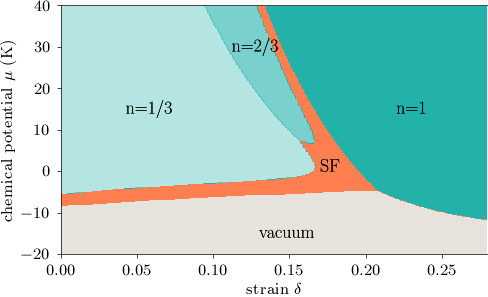

In [50]:
plt.style.reload_library()
with plt.style.context(plot_style['aps']):
    fig,ax = plt.subplots(1,1,constrained_layout=True)
    dgutils.fonts.set_custom_font(font_path)
    cMap = get_cmap(np.unique(data_PPD))
    p1 = ax.contourf(delta_PPD, mu_PPD, data_PPD, 5, vmin = 0, vmax = 5,cmap=cMap)

    ax.set_xlabel(r'strain $\delta$')
    ax.set_ylabel(r'chemical potential  $\mu$ (K)')
    
    ax.set_xlim(0,0.28)
    ax.set_ylim(-20,40)
    
#     plt.scatter(locator[0], locator[1])
    
    path_eff = [path_effects.withSimplePatchShadow(offset=(0.05, -0.05), shadow_rgbFace='k', alpha=0.9)]
    
    labels=['vacuum','SF',r'n=1/3',r'n=2/3',r'n=1']
    label_loc = [[0.13,-15],[0.17,1],[0.0425,15],[0.112,30],[0.22,15]]

    for lab,loc in zip(labels,label_loc):
        ax.text(*loc, lab, va='center',ha='left', path_effects=path_eff)

### With supersolid

In [51]:
#With supersolid data (energy, strain, mu)
supersolid = np.genfromtxt('../data/SSPPD2.csv',delimiter=",")
ss_strains = np.unique(supersolid[:,1])
ss_mus = np.unique(supersolid[:,2])

In [52]:
def ss_extractor(delta, mu, sampleset = supersolid):
    for arr in sampleset:
        el = list(arr)
        if round(el[1],3) == round(delta,3) and round(el[2],3) == round(mu,3):
            return el[0]
    return 0

In [53]:
mubar_PPD = np.zeros((ny_PPD,nx_PPD))
data_PPD = np.zeros((ny_PPD,nx_PPD))
energy_log = []
for i in range(nx_PPD):
    for j in range(ny_PPD):
        mubar_PPD[j,i] = mu_PPD[j]/norm_PPD[i]

for i, delta_r in enumerate(delta_PPD):
    for j, mu_r in enumerate(mu_PPD):
        ss_energy = ss_extractor(round(delta_r,3), round(mu_r,3))*16/(abs(V_PPD[i])+abs(Vp_PPD[i]))
        if ss_energy:
            data_PPD[j,i] = pref_state_SS_included(tbar_PPD[i],mubar_PPD[j,i],s_PPD[i],a_PPD[i], ss_energy)
            e_log_w = lst(tbar_PPD[i],mubar_PPD[j,i],s_PPD[i],a_PPD[i])
            e_log_w.insert(0,[delta_r,t_PPD[i],mu_r,V_PPD[i],Vp_PPD[i]])
            e_log_w.append(ss_energy)
            e_log_w.append([tbar_PPD[i],mubar_PPD[j,i],s_PPD[i],a_PPD[i]])
            energy_log.append(e_log_w)
        else:
            data_PPD[j,i] = pref_state_SS_included(tbar_PPD[i],mubar_PPD[j,i],s_PPD[i],a_PPD[i])

In [54]:
# totalcount=0
# testcount=0
# for i, delta_r in enumerate(delta_PPD):
#     for j, mu_r in enumerate(mu_PPD):
#         ss_energy = ss_extractor(round(delta_r,3), round(mu_r,3))
#         if ss_energy:
#             testcount += 1
#         totalcount += 1
# print(testcount)
# print(totalcount)

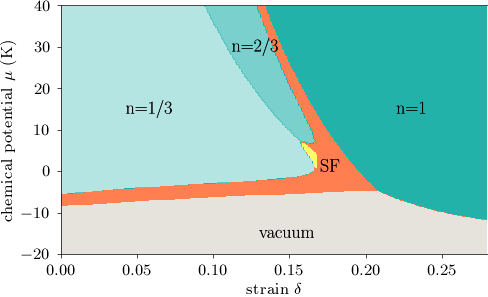

In [55]:
plt.style.reload_library()
with plt.style.context(plot_style['aps']):
    fig,ax = plt.subplots(1,1,constrained_layout=True)
    dgutils.fonts.set_custom_font(font_path)
    cMap = get_cmap(np.unique(data_PPD))
    p1 = ax.contourf(delta_PPD, mu_PPD, data_PPD, 6, vmin = 0, vmax = 6,cmap=cMap)

    ax.set_xlabel(r'strain $\delta$')
    ax.set_ylabel(r'chemical potential  $\mu$ (K)')
    
    ax.set_xlim(0,0.28)
    ax.set_ylim(-20,40)
    
#     plt.scatter(locator[0], locator[1])
    
    path_eff = [path_effects.withSimplePatchShadow(offset=(0.05, -0.05), shadow_rgbFace='k', alpha=0.9)]
    
    labels=['vacuum','SF',r'n=1/3',r'n=2/3',r'n=1']
    label_loc = [[0.13,-15],[0.17,1],[0.0425,15],[0.112,30],[0.22,15]]

    for lab,loc in zip(labels,label_loc):
        ax.text(*loc, lab, va='center',ha='left', path_effects=path_eff)
    
#    fig.savefig('../figures/mu_delta_phase_diagram_withS.pdf')

## Above figure support the fact that Supersolid phase is preferred between two lobes

In [57]:
## Manually fill the area with higher resolution
mubar = np.zeros((ny,nx))
data = np.zeros((ny,nx))
for i in range(nx):
    for j in range(ny):
        mubar[j,i] = mu_new[j]/norm[i]

for i in range(nx):
    for j in range(ny):
        data[j,i] = pref_state(tbar[i],mubar[j,i],s_lst[i],a_lst[i])

In [58]:
idxarr_high = np.argwhere(data==4)
sortedArr_high = idxarr_high[idxarr_high[:,1].argsort()]

147
0.15719999999999998


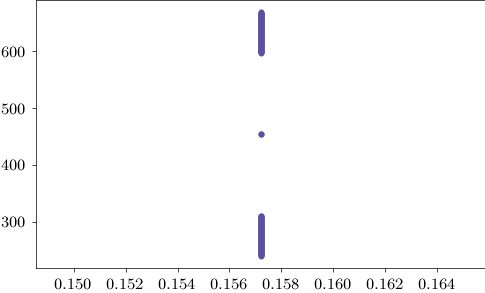

In [59]:
delta_number = 524
argArr = np.argwhere((sortedArr_high[:,1]==delta_number))
print(len(argArr))
target = sortedArr_high[argArr[0][0]:argArr[-1][0]+1]
targetsorted = target[target[:,0].argsort()]
plt.scatter([delta_new[delta_number],]*len(targetsorted),targetsorted[:,0])
print(delta_new[delta_number])

284
0.16679999999999998


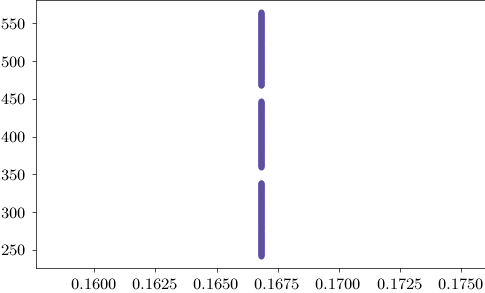

In [60]:
delta_number = 556
argArr = np.argwhere((sortedArr_high[:,1]==delta_number))
print(len(argArr))
target = sortedArr_high[argArr[0][0]:argArr[-1][0]+1]
targetsorted = target[target[:,0].argsort()]
plt.scatter([delta_new[delta_number],]*len(targetsorted),targetsorted[:,0])
print(delta_new[delta_number])

In [61]:
bigpad2 = []
mu_lst2 = []
for row in range(524,557):
    delta_number = row
    argArr = np.argwhere((sortedArr_high[:,1]==delta_number))
    target = sortedArr_high[argArr[0][0]:argArr[-1][0]+1]
    targetsorted = target[target[:,0].argsort()]
    mu_init = targetsorted[:,0][0]
    switch = 0
    pad = []
    for mu_idx in tuple(targetsorted[:,0][1:]):
        if mu_idx != mu_init+1 and switch == False:
            switch = not switch
        elif mu_idx != mu_init+1 and switch:
            switch = not switch
        if switch:
            pad.append(mu_idx)
        mu_init = mu_idx
    #print(pad)
    if len(pad) == 0:
        print("Not valid row number!")
    bigpad2.append(pad)

In [62]:
for row, i in enumerate(range(524,557)):
    for j in bigpad2[row]:
        if data[j,i] != 6.0:
            data[j,i] = 6.0

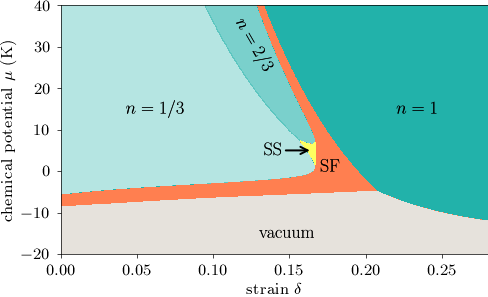

In [69]:
plt.style.reload_library()
with plt.style.context(plot_style['aps']):
    fig,ax = plt.subplots(1,1,constrained_layout=True)
    dgutils.fonts.set_custom_font(font_path)
    cMap = get_cmap(np.unique(data_PPD))
    p1 = ax.contourf(delta_new, mu_new, data, 6, vmin = 0, vmax = 6,cmap=cMap)

    ax.set_xlabel(r'strain $\delta$')
    ax.set_ylabel(r'chemical potential  $\mu$ (K)')
    
    ax.set_xlim(0,0.28)
    ax.set_ylim(-20,40)
    
#     plt.scatter(locator[0], locator[1])
    
    path_eff = [path_effects.withSimplePatchShadow(offset=(0.05, -0.05), shadow_rgbFace='k', alpha=0.9)]
    
    labels=['vacuum','SF',r'$n=1/3$',r'$n=2/3$',r'$n=1$', 'SS']
    label_loc = [[0.13,-15],[0.17,1],[0.0425,15],[0.112,30],[0.22,15],[0.133,5]]

    for lab,loc in zip(labels,label_loc):
        if '2/3' in lab:
            rotate = -60
        else:
            rotate = 0
        ax.text(*loc, lab, va='center',ha='left', path_effects=path_eff, rotation=rotate)
    
#     plt.arrow(0.155,5,0.005,0, width=0.1, head_width=0.03)
    ax.annotate("", xy=(0.166, 5), xytext=(0.145, 5),
            arrowprops=dict(arrowstyle="->"))
    
    fig.savefig('../figures/mu_delta_phase_diagram_withS_high.pdf')
    fig.savefig('../figures/mu_delta_phase_diagram_withS_high.svg')